# Build a varitaional quantum circuit in Qiskit
as opposed to the pre-built algorithms like VQE

In [1]:
import numpy as np
from scipy.optimize import minimize
import qiskit
from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from matplotlib import pyplot as plt

In [2]:
from qiskit_machine_learning.neural_networks import CircuitQNN

In [146]:
# linear entangler (as in scales linearly with trash qubits)
def get_entangler_map(L, num_trash, i_permut=1):
    result = []
    nums = list(range(L)) # here was the problem, it doesnt like when list elements are taken from numpy
    nums_compressed = nums.copy()[:L-num_trash]
    nums_trash = nums.copy()[-num_trash:]
    #print(nums, nums_compressed, nums_trash)
    # combine all trash qubits with themselves
    for trash_q in nums_trash[:-1]:
        result.append((trash_q+1,trash_q))
    # combine each of the trash qubits with every n-th
    repeated = list(nums_trash) * (L-num_trash) # repeat the list of trash indices cyclicly
    for i in range(L-num_trash):
        result.append((repeated[i_permut + i], nums_compressed[i]))
    return result

In [152]:
def QAE_Ansatz(L,num_trash, insert_barriers=False, parametrized_gate = "ry", entangling_gate = "cz"):
    entanglement = [get_entangler_map(L,num_trash,i_permut) for i_permut in range(num_trash)]
    return qiskit.circuit.library.TwoLocal(L, 
                                           parametrized_gate,
                                           entangling_gate,
                                           entanglement,
                                           reps=num_trash,
                                           insert_barriers=insert_barriers,
                                          )

Reproduce Carlos' Ansatz:

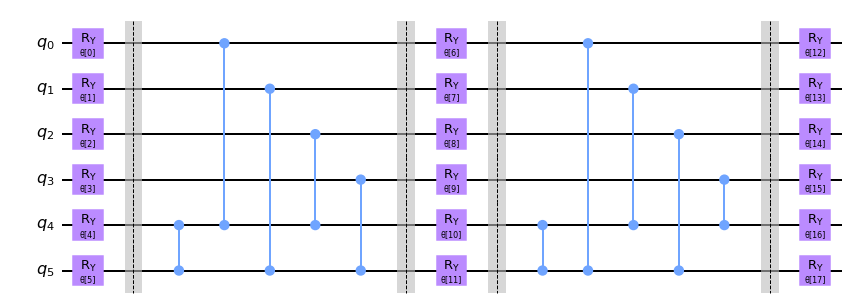

In [161]:
QAE_Ansatz(6,2,insert_barriers=True).draw("mpl")

Probably what we are going to use:

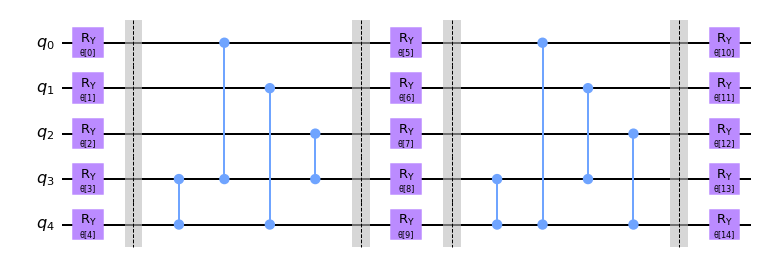

In [163]:
QAE_Ansatz(5,2,insert_barriers=True).draw("mpl")

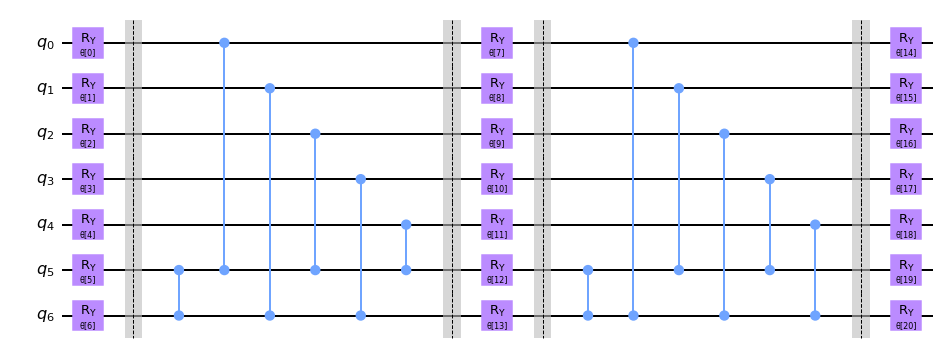

In [164]:
QAE_Ansatz(7,2,insert_barriers=True).draw("mpl")

some things (connecting trash qubits with each other can be improved maybe)

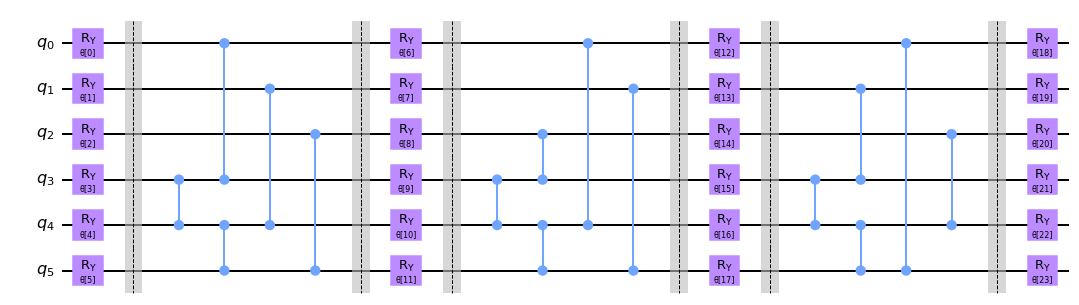

In [159]:
QAE_Ansatz(6,3,insert_barriers=True).draw("mpl")

In [154]:
# more complicated and as far as i can tell exponential
def get_entangler_map_exp(L, num_trash, i_permut=0):
    result = []
    nums = list(range(L))
    nums_compressed = nums.copy()[:L-num_trash]
    nums_trash = nums.copy()[-num_trash:]
    #print(nums, nums_compressed, nums_trash)
    # combine all trash qubits with themselves
    for trash_q in nums_trash[:-1]:
        result.append((trash_q+1,trash_q))
    # combine each of the trash qubits with every n-th
    permutations = list(itertools.permutations(nums_trash))
    for _,trash_q in enumerate(permutations[i_permut]):
        for comp_q in nums_compressed[_%num_trash::num_trash]: # combine each trash_q with even or odd site
            result.append((trash_q, comp_q))
    return result

[qiskit.circuit.library.TwoLocal(..) documentation](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html?highlight=twolocal#qiskit.circuit.library.TwoLocal)

<ipython-input-166-4c2416c0299c>:13: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circ2 = ansatz + measurement_circ
/home/kkottmann/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/qiskit/circuit/quantumcircuit.py:869: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)


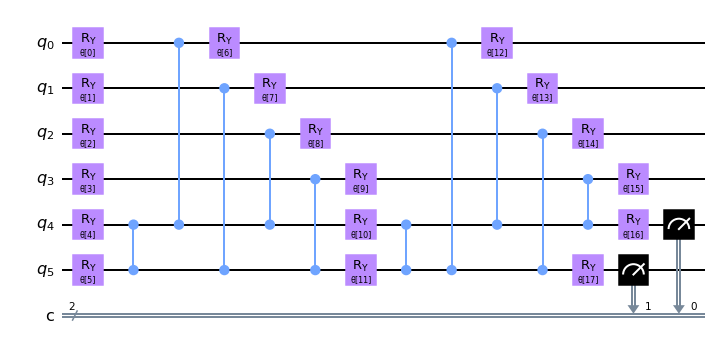

In [166]:
# Use Qiskit layer generator thingy because now it has everything it needs to get a gradient!
# Note that it has redundant Ry rotations at the end on the compression qubits, didnt find a clever way how to get rid of them, but this shouldnt change too much

# variational ansatz sub-circuit
ansatz = QAE_Ansatz(6,2)

# measurement circuit
qreg = qiskit.QuantumRegister(L, 'q')
creg = qiskit.ClassicalRegister(2, 'c')
measurement_circ = qiskit.QuantumCircuit(qreg, creg)
measurement_circ.measure(qreg[4], creg[0])
measurement_circ.measure(qreg[5], creg[1])
circ2 = ansatz + measurement_circ
circ2.decompose()
#print(circ2)
#measurement_circ.draw("mpl")
circ2.draw("mpl")

following [this tutorial on quantum neural networks](https://qiskit.org/documentation/machine-learning/tutorials/01_neural_networks.html)

In [10]:
qi_qasm = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=10)
qi_sv = QuantumInstance(Aer.get_backend('statevector_simulator'))

In [11]:
qnn4 = CircuitQNN(circ2, [], circ2.parameters, sparse=False, quantum_instance=qi_qasm)

In [12]:
input4 = np.random.rand(qnn4.num_inputs)
weights4 = np.random.rand(qnn4.num_weights)

In [13]:
qnn4.forward(input4, weights4)

array([[0.3, 0.2, 0.3, 0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ]])

In [14]:
qnn4.backward(input4, weights4)

(array([], shape=(1, 64, 0), dtype=float64),
 array([[[0.  , 0.05, 0.1 , ..., 0.  , 0.05, 0.05],
         [0.1 , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
         [0.  , 0.05, 0.  , ..., 0.  , 0.  , 0.05],
         ...,
         [0.  , 0.  , 0.  , ..., 0.  , 0.05, 0.  ],
         [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
         [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.05]]]))

## further insight
"As the qasm_simulator has shot noise we choose to use SPSA which is designed to perform under noisy conditions." in this [variational quantum classifier tutorial](https://qiskit.org/documentation/tutorials/machine_learning/03_vqc.html)  
has a cost function optimization "by hand" at the end [link](https://qiskit.org/textbook/ch-paper-implementations/vqls.html)

# Build Variational algorithm from this

In [16]:
from qiskit.algorithms.variational_algorithm import VariationalAlgorithm

In [23]:
VariationalAlgorithm(ansatz = circ2, optimizer = None)

# Qiskit Github error message
minimal example of error message

In [94]:
L = 6

In [136]:
def create_map(L,p=0):
    result = []
    for i in range(L-1):
        result.append(((p+i)%L,(p+i+2)%L))
    return result

In [137]:
map1 = create_map(L)
map2 = create_map(L,1)
print(map1)
print(map2)

[(0, 2), (1, 3), (2, 4), (3, 5), (4, 0)]
[(1, 3), (2, 4), (3, 5), (4, 0), (5, 1)]


In [138]:
map_by_hand1 = [(0, 2), (1, 3), (2, 4), (3, 5), (4, 0)]
map_by_hand2 = [(1, 3), (2, 4), (3, 5), (4, 0), (5, 1)]
print(map_by_hand1)
print(map_by_hand2)

[(0, 2), (1, 3), (2, 4), (3, 5), (4, 0)]
[(1, 3), (2, 4), (3, 5), (4, 0), (5, 1)]


In [139]:
map1 == map_by_hand1, map2 == map_by_hand2

(True, True)

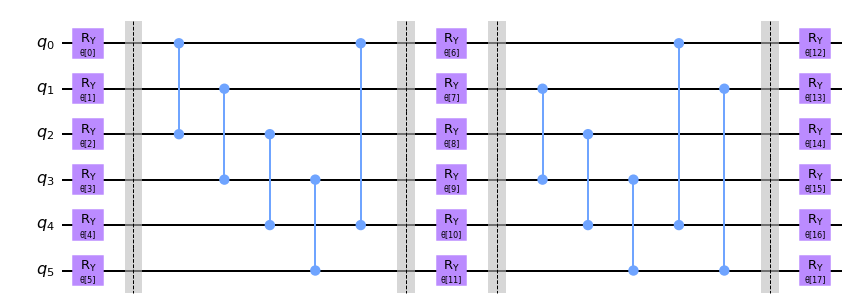

In [140]:
ansatz = qiskit.circuit.library.TwoLocal(L,"ry","cz",[map1,map2],reps=2, insert_barriers=True)
ansatz.draw("mpl")

In [133]:
map1 = get_entangler_map(6,2)
map2 = get_entangler_map(6,2,1)

In [134]:
print(map1)
print(map2)

[(5, 4), (5, 0), (4, 1), (5, 2), (4, 3)]
[(5, 4), (5, 0), (4, 1), (5, 2), (4, 3)]


In [135]:
ansatz = qiskit.circuit.library.TwoLocal(L,"ry","cz",[map1,map2],reps=2, insert_barriers=True)
ansatz.draw("mpl")

ValueError: Invalid value of entanglement: [[(5, 4), (5, 0), (4, 1), (5, 2), (4, 3)], [(5, 4), (5, 0), (4, 1), (5, 2), (4, 3)]]

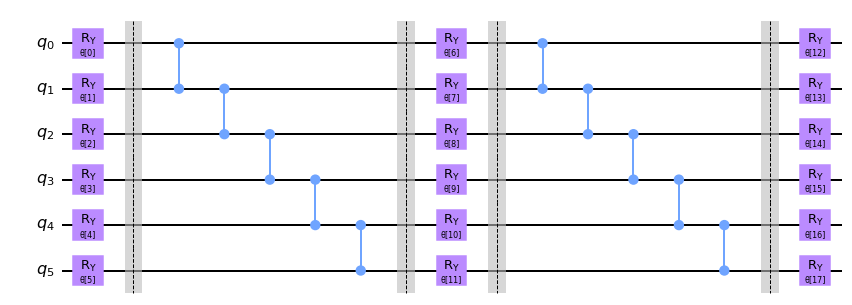

In [107]:
ansatz = qiskit.circuit.library.TwoLocal(L,"ry","cz",[map_by_hand],reps=2, insert_barriers=True)
ansatz.draw("mpl")